In [26]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import en_core_web_lg # python -m spacy download en_core_web_lg
import matplotlib.pyplot as plt
from keras.layers import TextVectorization, Embedding, LSTM, Dense, Bidirectional, Input
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.initializers import Constant
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from utils import stratified_split
from preprocessing import preprocess_df

In [9]:
model_dir = 'models'
model_name = 'bilstm_classifier.keras'
params_dict = {'dropout': 0.3,
                'rec_dropout': 0.3,
                'learning_rate': 0.006,
                'patience': 4,
                'units': 128,
                'batch': 256,
                'epochs': 15}

In [10]:
def get_x_y(df: pd.DataFrame, feature: str='preprocessed_text', target_class: str='generated'):
    x = df[feature]
    y = np.array(df[target_class]).astype('float32').reshape((-1,1))
    
    return x, y

In [11]:
df = pd.read_csv('data/preprocessed_df.csv', header=0)
df.head()

,title,text,generated,preprocessed_text
0,Sexhow railway station,Sexhow railway station was a railway station b...,0,sexhow railway station railway station built s...
1,Etiäinen,"In Finnish folklore, all places and things, an...",0,finnish folklore place thing also human being ...
2,Inverse function theorem,"In mathematics, specifically differential calc...",0,mathematics specifically differential calculus...
3,Stepping on Roses,is a Japanese shōjo manga series written and i...,0,japanese shōjo manga series written illustrate...
4,Rob Bradley,"Robert Milner ""Rob"" Bradley, Jr. (born August ...",0,robert milner rob bradley born august 1970 gre...


In [12]:
train_set, valid_set, test_set = stratified_split(df)

# shuffle rows
train_set = train_set.sample(frac=1).reset_index(drop=True)
test_set = test_set.sample(frac=1).reset_index(drop=True)
valid_set = valid_set.sample(frac=1).reset_index(drop=True)

x_train, y_train = get_x_y(train_set)
x_valid, y_valid = get_x_y(valid_set)
x_test, y_test = get_x_y(test_set)

In [13]:
nlp = en_core_web_lg.load()
Vectorizer = TextVectorization()

In [14]:
train_valid_data = pd.DataFrame(pd.concat([x_train, x_valid], axis=0))

In [15]:
#fit the vectorizer on the text and extract the corpus vocabulary
Vectorizer.adapt(train_valid_data['preprocessed_text'].to_numpy())
vocab = Vectorizer.get_vocabulary()

In [16]:
#generate the embedding matrix
num_tokens = len(vocab)
embedding_dim = len(nlp('The').vector) #300
embedding_matrix = np.zeros((num_tokens, embedding_dim))
print(num_tokens, embedding_dim)
cnt_oov = 0
for i, word in enumerate(vocab):
    doc = nlp(str(word))
    embedding_matrix[i] = doc.vector
    if doc and doc[0].is_oov:
        cnt_oov += 1

444006 300


In [17]:
cnt_oov / num_tokens * 100

79.81964207690886

In [18]:
#Load the embedding matrix as the weights matrix for the embedding layer and set trainable to False
Embedding_layer=Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False)

In [19]:
model = Sequential()
model.add(Input(shape=(1,), dtype=tf.string))
model.add(Vectorizer)
model.add(Embedding_layer)
model.add(Bidirectional(LSTM(units=params_dict['units'],
                            recurrent_dropout=params_dict['rec_dropout'],)))
                            # return_sequences=True)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
            optimizer=Adam(learning_rate=params_dict['learning_rate']),
            metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 300)      │   133,201,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,641,353 (509.80 MB)

 Trainable params: 439,553 (1.68 MB)

 Non-trainable params: 133,201,800 (508.12 MB)

In [20]:
callback = EarlyStopping(
            monitor="val_loss",
            patience=params_dict['patience'],
            restore_best_weights=True)

history = model.fit(x_train,
                    y_train,
                    validation_data=(x_valid, y_valid),
                    verbose=1,
                    batch_size=params_dict['batch'],
                    epochs=params_dict['epochs'],
                    callbacks=[callback])

Epoch 1/15


352/352 ━━━━━━━━━━━━━━━━━━━━ 152s 425ms/step - accuracy: 0.7061 - loss: 0.5320 - val_accuracy: 0.8468 - val_loss: 0.3571
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 149s 423ms/step - accuracy: 0.8518 - loss: 0.3396 - val_accuracy: 0.8688 - val_loss: 0.3038
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 204s 430ms/step - accuracy: 0.8754 - loss: 0.2921 - val_accuracy: 0.8807 - val_loss: 0.2837
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 202s 429ms/step - accuracy: 0.8845 - loss: 0.2760 - val_accuracy: 0.8879 - val_loss: 0.2720
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 153s 434ms/step - accuracy: 0.8924 - loss: 0.2575 - val_accuracy: 0.8885 - val_loss: 0.2683
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 202s 434ms/step - accuracy: 0.8979 - loss: 0.2478 - val_accuracy: 0.8954 - val_loss: 0.2518
Epoch 7/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 202s 435ms/step - accuracy: 0.9064 - loss: 0.2281 - val_accuracy: 0.9006 - val_loss: 0.2395
Epoch 8/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 151s 429ms/step - accuracy: 0.9130 - loss: 0.21

In [21]:
model.save(os.path.join(model_dir, model_name))

In [22]:
model_loaded = load_model(os.path.join(model_dir, model_name))

In [18]:
def get_predictions_bilstm(model, x_test):
    predictions = model.predict(x_test)
    predictions = np.where(predictions.max(axis=-1) > 0.5, 1, 0)
    return predictions

In [19]:
def acc_loss(history):
    # Visualize Loss & Accuracy

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

def conf_matrix(y_true, y_pred):
    cm = confusion_matrix(np.array(y_true), y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

In [20]:
def validate_model_bilstm(model, history, x_test, y_true):
    print('#### VALIDATION ####')
    print('Test set evaluation:')
    model.evaluate(x_test, y_true, verbose=1)

    y_pred = get_predictions_bilstm(model, x_test)
    print('Classification report:')
    print(classification_report(y_true, y_pred))

    acc_loss(history)
    conf_matrix(y_true, y_pred.flatten())

#### VALIDATION ####
Test set evaluation:
  9/938 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - accuracy: 0.7056 - loss: 0.7676

938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.6975 - loss: 0.8449
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step
Classification report:
              precision    recall  f1-score   support

         0.0       0.86      0.48      0.61     15000
         1.0       0.64      0.92      0.75     15000

    accuracy                           0.70     30000
   macro avg       0.75      0.70      0.68     30000
weighted avg       0.75      0.70      0.68     30000



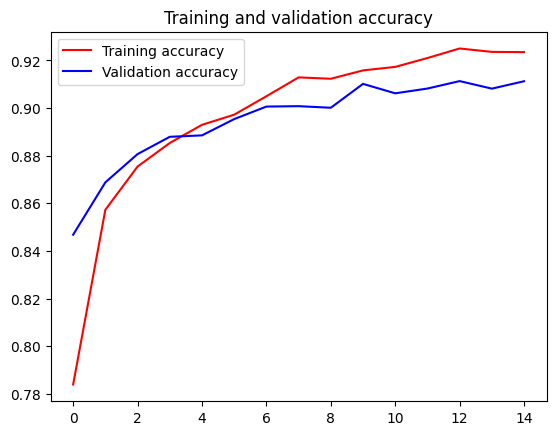

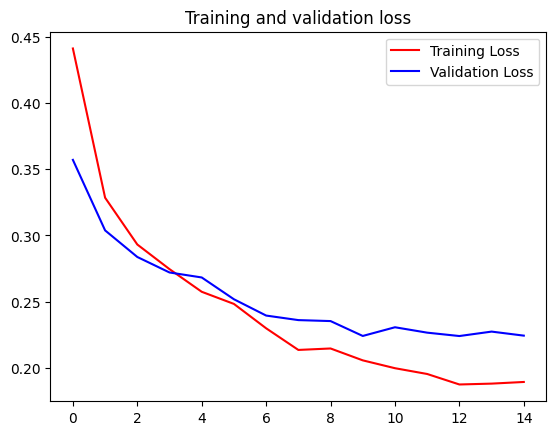

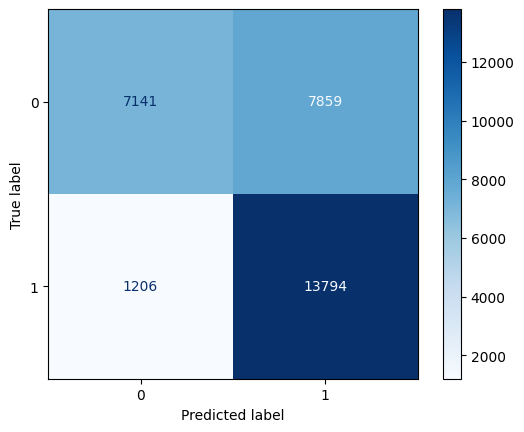

In [26]:
validate_model_bilstm(model_loaded, history, x_test, y_test)

# Predicting on Different Data

In [25]:
def get_extra_data(path):
    #load to df
    data = pd.read_pickle(path)
    data = pd.DataFrame({'text': data})
    # add labels
    labels = np.ones(data.shape[0])
    data['generated'] = labels
    return data

In [24]:
def validate_predictions_bilstm(model, x_test, y_true):
    print('#### VALIDATION ####')

    y_pred = get_predictions_bilstm(model, x_test)
    print('Classification report:')
    print(classification_report(y_true, y_pred, zero_division=0))

    conf_matrix(y_true, y_pred.flatten())

In [43]:
def predict_data(model, data):
    # prepare data
    data = preprocess_df(data)
    x = data['preprocessed_text']
    y = np.array(data['generated'])
    
    validate_predictions_bilstm(model, x, y)

#### VALIDATION ####
  1/450 ━━━━━━━━━━━━━━━━━━━━ 1:13 164ms/step

450/450 ━━━━━━━━━━━━━━━━━━━━ 68s 151ms/step
Classification report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.59      0.74     14400

    accuracy                           0.59     14400
   macro avg       0.50      0.30      0.37     14400
weighted avg       1.00      0.59      0.74     14400



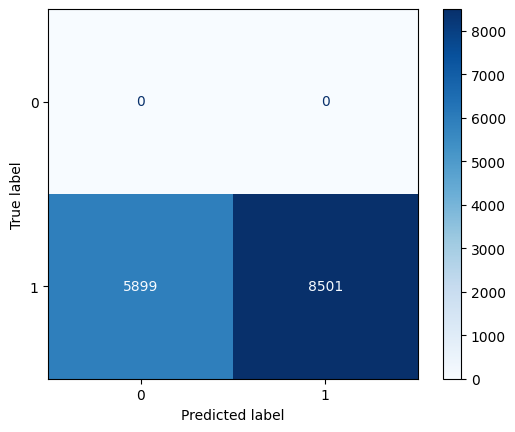

In [30]:
df_chatgpt = get_extra_data('data/extras/chat_gpt.pkl')
predict_data(model_loaded, df_chatgpt)

#### VALIDATION ####
 96/450 ━━━━━━━━━━━━━━━━━━━━ 55s 157ms/step

450/450 ━━━━━━━━━━━━━━━━━━━━ 67s 149ms/step
Classification report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.63      0.78     14400

    accuracy                           0.63     14400
   macro avg       0.50      0.32      0.39     14400
weighted avg       1.00      0.63      0.78     14400



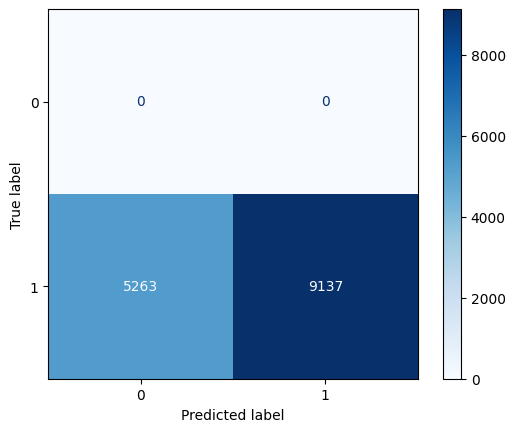

In [31]:
df_davinci = get_extra_data('data/extras/davinci.pkl')
predict_data(model_loaded, df_davinci)

#### VALIDATION ####
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.42      0.60      1375
           1       0.00      0.67      0.01         3

    accuracy                           0.43      1378
   macro avg       0.50      0.55      0.30      1378
weighted avg       1.00      0.43      0.59      1378



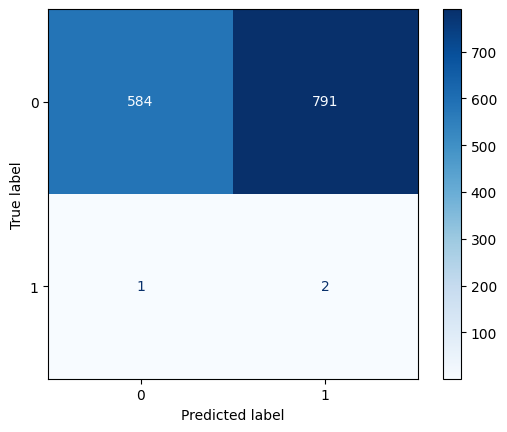

In [32]:
df_essays = pd.read_csv('data/extras/train_essays.csv', header=0)
predict_data(model_loaded, df_essays)

In [33]:
df_palm = pd.read_csv('data/extras/LLM_generated_essay_PaLM.csv', header=0)
df_falcon = pd.read_csv('data/extras/falcon_180b_v1.csv', header=0)
df_llama = pd.read_csv('data/extras/llama_70b_v1.csv', header=0)

df_llama.rename(columns={'generated_text': 'text'}, inplace=True)
df_falcon.rename(columns={'generated_text': 'text'}, inplace=True)

df_falcon['generated'] = np.ones(df_falcon.shape[0])
df_llama['generated'] = np.ones(df_llama.shape[0])

df_extras = pd.concat([df_palm[['text', 'generated']], df_falcon[['text', 'generated']], df_llama[['text', 'generated']]], axis=0)
print(df_extras.shape)
df_extras.head()

(3611, 2)


,text,generated
0,## The Advantages of Limiting Car Usage\n\nIn ...,1.0
1,"The United States is a car-dependent nation, w...",1.0
2,"In recent years, there has been a growing move...",1.0
3,"In recent years, there has been a growing move...",1.0
4,"In the past few decades, the United States has...",1.0


#### VALIDATION ####
113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step
Classification report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.44      0.61      3611

    accuracy                           0.44      3611
   macro avg       0.50      0.22      0.31      3611
weighted avg       1.00      0.44      0.61      3611



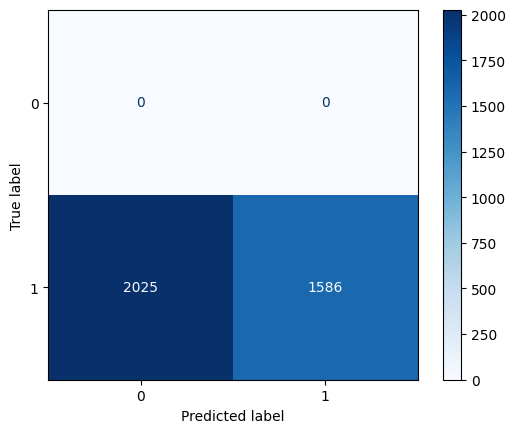

In [34]:
predict_data(model_loaded, df_extras)

# BiLSTM with Gensim FastText
https://www.kaggle.com/code/guichristmann/lstm-classification-model-with-word2vec
https://www.kaggle.com/code/nikzzzn/lstm-nn-fasttext-embedding

In [39]:
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional, Embedding
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l1, l2
from keras.optimizers import Adam

from gensim.models import FastText
import gensim.downloader as api

from utils import stratified_split, get_x_y

In [2]:
model_dir = 'models'
model_name = 'bilstm_classifier_fasttext.keras'
params_dict = {'dropout': 0.3,
                'rec_dropout': 0.3,
                'learning_rate': 0.006,
                'patience': 4,
                'units': 128,
                'batch': 256,
                'epochs': 15}

In [3]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
MAX_SEQ_LEN = 128 #try 256 as well

In [5]:
# Loading dataset
df = pd.read_csv('data/preprocessed_df.csv', header=0)

In [6]:
train_set, valid_set, test_set = stratified_split(df)

# shuffle rows
train_set = train_set.sample(frac=1).reset_index(drop=True)
test_set = test_set.sample(frac=1).reset_index(drop=True)
valid_set = valid_set.sample(frac=1).reset_index(drop=True)

x_train, y_train = get_x_y(train_set)
x_valid, y_valid = get_x_y(valid_set)
x_test, y_test = get_x_y(test_set)

In [7]:
train_valid_set = pd.concat([train_set, valid_set], axis=0)

In [8]:
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(train_valid_set['preprocessed_text'])
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)
sequences_valid = tokenizer.texts_to_sequences(x_valid)
word_index = tokenizer.word_index

train_padded = sequence.pad_sequences(sequences_train, maxlen=MAX_SEQ_LEN, padding = 'post')
test_padded = sequence.pad_sequences(sequences_test, maxlen=MAX_SEQ_LEN, padding = 'post')
valid_padded = sequence.pad_sequences(sequences_valid, maxlen=MAX_SEQ_LEN, padding = 'post')

In [9]:
fasttext = api.load('fasttext-wiki-news-subwords-300')
embedding_dim = 300

2024-05-22 15:53:09,414 : INFO : loading projection weights from /home/mfain/gensim-data/fasttext-wiki-news-subwords-300/fasttext-wiki-news-subwords-300.gz
2024-05-22 15:55:23,464 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (999999, 300) matrix of type float32 from /home/mfain/gensim-data/fasttext-wiki-news-subwords-300/fasttext-wiki-news-subwords-300.gz', 'binary': False, 'encoding': 'utf8', 'datetime': '2024-05-22T15:55:23.464462', 'gensim': '4.3.2', 'python': '3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]', 'platform': 'Linux-5.10.0-29-amd64-x86_64-with-glibc2.31', 'event': 'load_word2vec_format'}


In [12]:
vocab_size = len(word_index) + 1

weight_matrix = np.zeros((vocab_size, embedding_dim))
cnt = 0
oov = []
for word, i in word_index.items():
    try:
        embedding_vector = fasttext[word]
        weight_matrix[i] = embedding_vector
    except KeyError:
        cnt += 1
        oov.append(word)
        weight_matrix[i] = np.random.uniform(-5, 5, embedding_dim)
cnt

343807

In [14]:
vocab_size

444005

In [17]:
model = Sequential()
model.add(Input(shape=(MAX_SEQ_LEN,), dtype='int32'))
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[weight_matrix]))

model.add(Bidirectional(LSTM(units = 512, kernel_regularizer=l1(0.000001), return_sequences = True)))
model.add(Dropout(rate = 0.2))
model.add(Bidirectional(LSTM(units = 256, kernel_regularizer=l1(0.000001), return_sequences = True)))
model.add(Dropout(rate = 0.2))
model.add(Bidirectional(LSTM(units = 128, kernel_regularizer=l1(0.000001))))
model.add(Dropout(rate = 0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
            optimizer=Adam(learning_rate=params_dict['learning_rate']),
            metrics=['accuracy'])

model.summary()

2024-05-22 16:12:40.891298: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-22 16:12:40.893450: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-22 16:12:40.918395: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required l

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 128, 300)       │   133,201,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128, 1024)      │     3,330,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128, 512)       │     2,623,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,844,445 (533.46 MB)

 Trainable params: 139,844,445 (533.46 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
callback = EarlyStopping(
            monitor="val_loss",
            patience=params_dict['patience'],
            restore_best_weights=True)

history = model.fit(train_padded,
                    y_train,
                    validation_data=(valid_padded, y_valid),
                    verbose=1,
                    batch_size=params_dict['batch'],
                    epochs=params_dict['epochs'],
                    callbacks=[callback])

Epoch 1/15


/home/mfain/anaconda/envs/bilstm-venv/lib/python3.11/site-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 133201500 elements. This may consume a large amount of memory.
  warnings.warn(


352/352 ━━━━━━━━━━━━━━━━━━━━ 765s 2s/step - accuracy: 0.5649 - loss: 0.7990 - val_accuracy: 0.7644 - val_loss: 0.6332
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 793s 2s/step - accuracy: 0.7985 - loss: 0.5869 - val_accuracy: 0.8038 - val_loss: 0.5423
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 799s 2s/step - accuracy: 0.8581 - loss: 0.4868 - val_accuracy: 0.8501 - val_loss: 0.5690
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 802s 2s/step - accuracy: 0.9181 - loss: 0.4333 - val_accuracy: 0.8834 - val_loss: 0.4822
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 801s 2s/step - accuracy: 0.9612 - loss: 0.3118 - val_accuracy: 0.8810 - val_loss: 0.5220
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 801s 2s/step - accuracy: 0.9775 - loss: 0.2605 - val_accuracy: 0.8855 - val_loss: 0.5165
Epoch 7/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 802s 2s/step - accuracy: 0.9779 - loss: 0.2606 - val_accuracy: 0.8906 - val_loss: 0.5129
Epoch 8/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 802s 2s/step - accuracy: 0.9734 - loss: 0.2964 - val_accuracy: 0.896

#### VALIDATION ####
Test set evaluation:
938/938 ━━━━━━━━━━━━━━━━━━━━ 157s 168ms/step - accuracy: 0.8851 - loss: 0.4806
938/938 ━━━━━━━━━━━━━━━━━━━━ 157s 167ms/step
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     15000
           1       0.87      0.90      0.89     15000

    accuracy                           0.88     30000
   macro avg       0.88      0.88      0.88     30000
weighted avg       0.88      0.88      0.88     30000



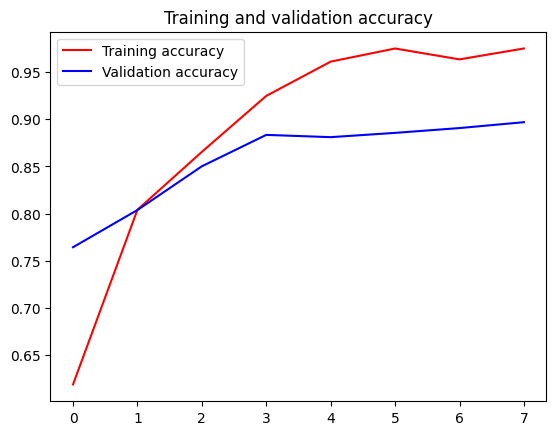

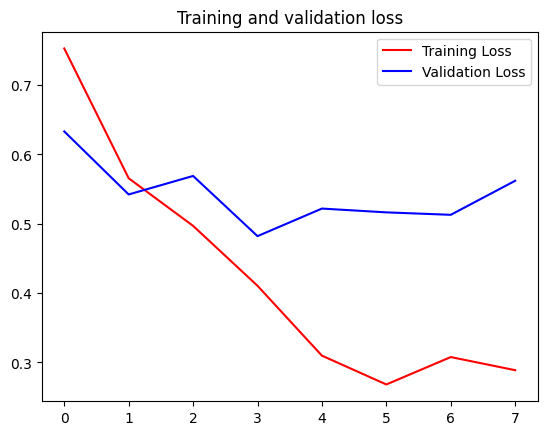

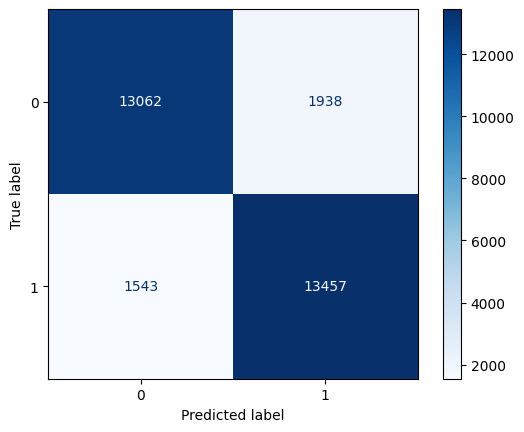

In [29]:
validate_model_bilstm(model, history, test_padded, y_test)

In [28]:
def predict_new_data(model, tokenizer, data):
    # prepare data
    data = preprocess_df(data)
    x = data['preprocessed_text']
    seq = tokenizer.texts_to_sequences(x)
    padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=MAX_SEQ_LEN, padding = 'post')
    y = np.array(data['generated'])
    
    validate_predictions_bilstm(model, padded, y)

#### VALIDATION ####
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1375
           1       0.00      0.00      0.00         3

    accuracy                           0.93      1378
   macro avg       0.50      0.47      0.48      1378
weighted avg       1.00      0.93      0.96      1378



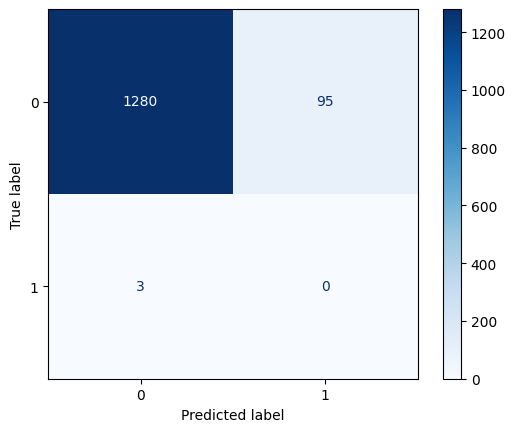

In [33]:
df_essays = pd.read_csv('data/extras/train_essays.csv', header=0)
predict_new_data(model, tokenizer, df_essays)

In [34]:
df_palm = pd.read_csv('data/extras/LLM_generated_essay_PaLM.csv', header=0)
df_falcon = pd.read_csv('data/extras/falcon_180b_v1.csv', header=0)
df_llama = pd.read_csv('data/extras/llama_70b_v1.csv', header=0)

df_llama.rename(columns={'generated_text': 'text'}, inplace=True)
df_falcon.rename(columns={'generated_text': 'text'}, inplace=True)

df_falcon['generated'] = np.ones(df_falcon.shape[0])
df_llama['generated'] = np.ones(df_llama.shape[0])

df_extras = pd.concat([df_palm[['text', 'generated']], df_falcon[['text', 'generated']], df_llama[['text', 'generated']]], axis=0)
print(df_extras.shape)
df_extras.head()

(3611, 2)


,text,generated
0,## The Advantages of Limiting Car Usage\n\nIn ...,1.0
1,"The United States is a car-dependent nation, w...",1.0
2,"In recent years, there has been a growing move...",1.0
3,"In recent years, there has been a growing move...",1.0
4,"In the past few decades, the United States has...",1.0


#### VALIDATION ####
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 167ms/step
Classification report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.44      0.61      3611

    accuracy                           0.44      3611
   macro avg       0.50      0.22      0.31      3611
weighted avg       1.00      0.44      0.61      3611



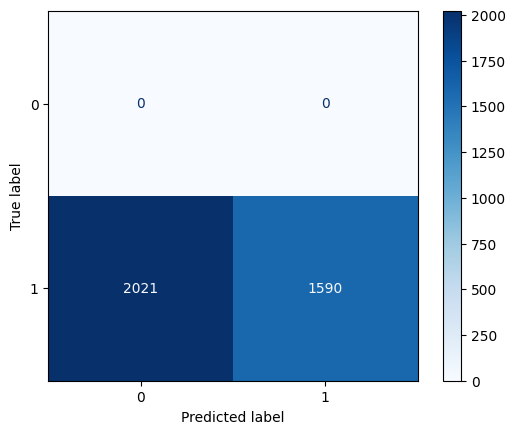

In [35]:
predict_new_data(model, tokenizer, df_extras)

In [45]:
model = Sequential()
model.add(Input(shape=(MAX_SEQ_LEN,)))
model.add(Embedding(vocab_size, embedding_dim, weights=[weight_matrix],
                              input_length=MAX_SEQ_LEN))
model.add(Bidirectional(LSTM(units=params_dict['units'],
                            recurrent_dropout=params_dict['rec_dropout'],)))
                            # return_sequences=True)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
            optimizer=Adam(learning_rate=params_dict['learning_rate']),
            metrics=['accuracy'])
model.summary()

/home/mfain/anaconda/envs/bilstm-venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 128, 300)       │   133,201,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,641,053 (509.80 MB)

 Trainable params: 133,641,053 (509.80 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
callback = EarlyStopping(
            monitor="val_loss",
            patience=params_dict['patience'],
            restore_best_weights=True)

history = model.fit(train_padded[:30000],
                    y_train[:30000],
                    validation_data=(valid_padded[:10000], y_valid[:10000]),
                    verbose=1,
                    batch_size=params_dict['batch'],
                    epochs=params_dict['epochs'],
                    callbacks=[callback])

Epoch 1/15


/home/mfain/anaconda/envs/bilstm-venv/lib/python3.11/site-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 133201500 elements. This may consume a large amount of memory.
  warnings.warn(


118/118 ━━━━━━━━━━━━━━━━━━━━ 50s 402ms/step - accuracy: 0.6713 - loss: 0.5825 - val_accuracy: 0.8615 - val_loss: 0.3426
Epoch 2/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 47s 395ms/step - accuracy: 0.9021 - loss: 0.2482 - val_accuracy: 0.8859 - val_loss: 0.2793
Epoch 3/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 82s 394ms/step - accuracy: 0.9698 - loss: 0.0851 - val_accuracy: 0.9014 - val_loss: 0.2737
Epoch 4/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 82s 394ms/step - accuracy: 0.9943 - loss: 0.0205 - val_accuracy: 0.9054 - val_loss: 0.3574
Epoch 5/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 82s 394ms/step - accuracy: 0.9981 - loss: 0.0075 - val_accuracy: 0.9023 - val_loss: 0.3486
Epoch 6/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 82s 394ms/step - accuracy: 0.9991 - loss: 0.0037 - val_accuracy: 0.9042 - val_loss: 0.4000
Epoch 7/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 82s 393ms/step - accuracy: 0.9994 - loss: 0.0035 - val_accuracy: 0.9080 - val_loss: 0.4137


#### VALIDATION ####
Test set evaluation:
938/938 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step - accuracy: 0.8997 - loss: 0.2868
938/938 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     15000
           1       0.89      0.91      0.90     15000

    accuracy                           0.90     30000
   macro avg       0.90      0.90      0.90     30000
weighted avg       0.90      0.90      0.90     30000



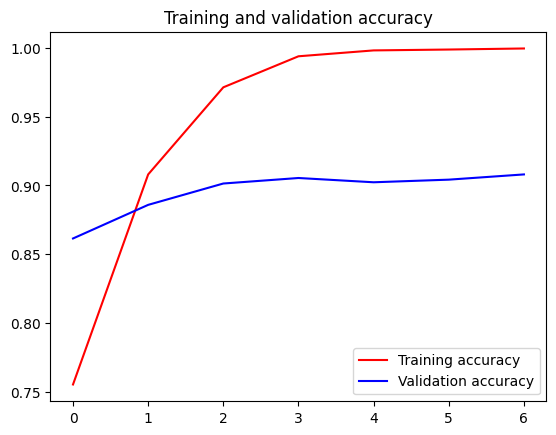

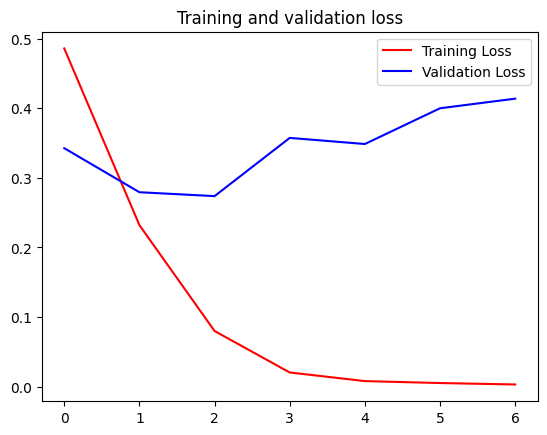

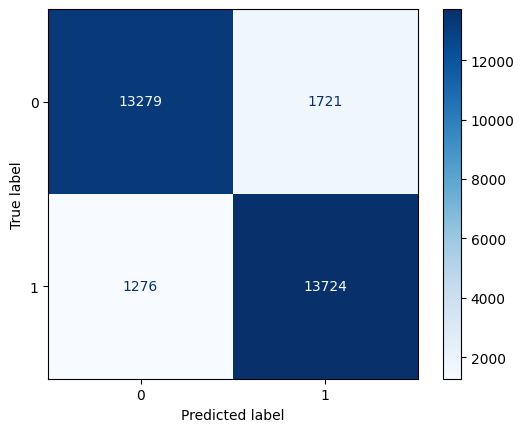

In [47]:
validate_model_bilstm(model, history, test_padded, y_test)

#### VALIDATION ####
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1375
           1       0.00      0.00      0.00         3

    accuracy                           0.95      1378
   macro avg       0.50      0.48      0.49      1378
weighted avg       1.00      0.95      0.97      1378



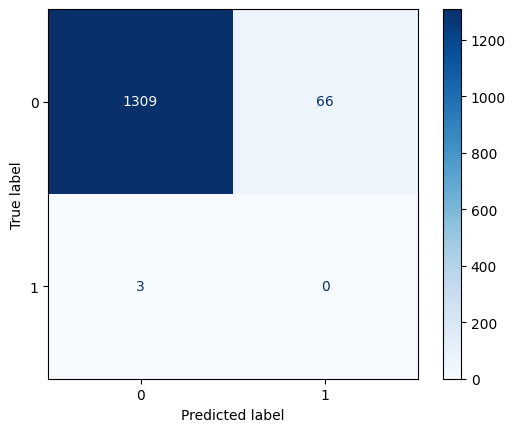

In [38]:
df_essays = pd.read_csv('data/extras/train_essays.csv', header=0)
predict_new_data(model, tokenizer, df_essays)

In [39]:
df_palm = pd.read_csv('data/extras/LLM_generated_essay_PaLM.csv', header=0)
df_falcon = pd.read_csv('data/extras/falcon_180b_v1.csv', header=0)
df_llama = pd.read_csv('data/extras/llama_70b_v1.csv', header=0)

df_llama.rename(columns={'generated_text': 'text'}, inplace=True)
df_falcon.rename(columns={'generated_text': 'text'}, inplace=True)

df_falcon['generated'] = np.ones(df_falcon.shape[0])
df_llama['generated'] = np.ones(df_llama.shape[0])

df_extras = pd.concat([df_palm[['text', 'generated']], df_falcon[['text', 'generated']], df_llama[['text', 'generated']]], axis=0)
print(df_extras.shape)
df_extras.head()

(3611, 2)


,text,generated
0,## The Advantages of Limiting Car Usage\n\nIn ...,1.0
1,"The United States is a car-dependent nation, w...",1.0
2,"In recent years, there has been a growing move...",1.0
3,"In recent years, there has been a growing move...",1.0
4,"In the past few decades, the United States has...",1.0


#### VALIDATION ####
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
Classification report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.46      0.63      3611

    accuracy                           0.46      3611
   macro avg       0.50      0.23      0.32      3611
weighted avg       1.00      0.46      0.63      3611



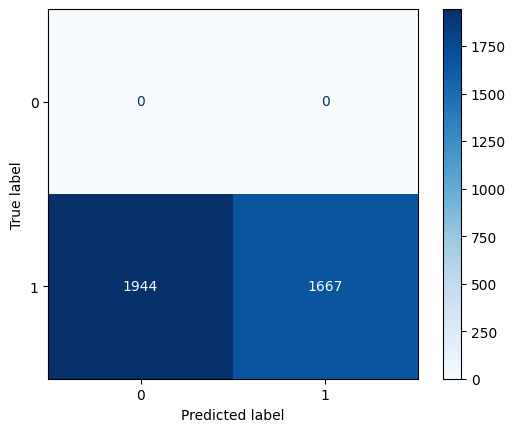

In [40]:
predict_new_data(model, tokenizer, df_extras)

# FastText

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import TextVectorization, Embedding, LSTM, Dense, Bidirectional, Input, Dropout
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.initializers import Constant
from tensorflow.keras.models import load_model
from keras.regularizers import l1, l2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from gensim.models import FastText

from utils import stratified_split, get_x_y
from preprocessing import preprocess_df

In [2]:
model_dir = 'models'
model_name = 'bilstm_classifier_fasttext.keras'
embedding_dim = 200
params_dict = {'dropout': 0.3,
                'rec_dropout': 0.3,
                'learning_rate': 0.006,
                'patience': 4,
                'units': 128,
                'batch': 256,
                'epochs': 15}

MAX_SEQ_LEN = 128

In [3]:
df = pd.read_csv('data/preprocessed_df.csv', header=0)

In [4]:
train_set, valid_set, test_set = stratified_split(df)

# shuffle rows
train_set = train_set.sample(frac=1).reset_index(drop=True)
test_set = test_set.sample(frac=1).reset_index(drop=True)
valid_set = valid_set.sample(frac=1).reset_index(drop=True)

x_train, y_train = get_x_y(train_set)
x_valid, y_valid = get_x_y(valid_set)
x_test, y_test = get_x_y(test_set)

In [5]:
train_valid_set = pd.concat([train_set, valid_set], axis=0)
docs = [doc.split() for doc in train_valid_set['preprocessed_text'].values]

In [6]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [7]:
ft = FastText(vector_size=embedding_dim, window=2, min_count=1, seed=33)
ft.build_vocab(docs)
ft.train(docs, total_examples=ft.corpus_count, epochs=10)

2024-05-24 10:24:39,003 : INFO : FastText lifecycle event {'params': 'FastText<vocab=0, vector_size=200, alpha=0.025>', 'datetime': '2024-05-24T10:24:39.003335', 'gensim': '4.3.2', 'python': '3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]', 'platform': 'Linux-5.10.0-29-amd64-x86_64-with-glibc2.31', 'event': 'created'}
2024-05-24 10:24:39,004 : INFO : collecting all words and their counts
2024-05-24 10:24:39,005 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-05-24 10:24:39,135 : INFO : PROGRESS: at sentence #10000, processed 947787 words, keeping 86319 word types
2024-05-24 10:24:39,276 : INFO : PROGRESS: at sentence #20000, processed 1899508 words, keeping 136446 word types
2024-05-24 10:24:39,427 : INFO : PROGRESS: at sentence #30000, processed 2849394 words, keeping 177614 word types
2024-05-24 10:24:39,565 : INFO : PROGRESS: at sentence #40000, processed 3801683 words, keeping 214760 word types
2024-05-24 10:24:39,708 : INFO : PROGRESS: at sentenc

(112715079, 113754170)

In [8]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=True)
tokenizer.fit_on_texts(docs)

sequence_train = tokenizer.texts_to_sequences(train_set['preprocessed_text'].values)
train_padded = tf.keras.preprocessing.sequence.pad_sequences(sequence_train, maxlen=MAX_SEQ_LEN, padding='post')

sequences_test = tokenizer.texts_to_sequences(x_test)
sequences_valid = tokenizer.texts_to_sequences(x_valid)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(sequences_test, maxlen=MAX_SEQ_LEN, padding = 'post')
valid_padded = tf.keras.preprocessing.sequence.pad_sequences(sequences_valid, maxlen=MAX_SEQ_LEN, padding = 'post')

In [9]:
# extract fasttext learned embedding and put them in a numpy array

embedding_matrix_ft = np.random.random((len(tokenizer.word_index) + 1, ft.vector_size))

pas = 0
for word,i in tokenizer.word_index.items():
    
    try:
        embedding_matrix_ft[i] = ft.wv[word]
    except:
        pas+=1

In [10]:
pas

0

In [15]:
model = Sequential()
model.add(Input(shape=(MAX_SEQ_LEN,), dtype='int32'))
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix_ft], trainable=False))

model.add(Bidirectional(LSTM(units = 512, kernel_regularizer=l1(0.000001), return_sequences = True)))
model.add(Dropout(rate = 0.2))
model.add(Bidirectional(LSTM(units = 256, kernel_regularizer=l1(0.000001), return_sequences = True)))
model.add(Dropout(rate = 0.2))
model.add(Bidirectional(LSTM(units = 128, kernel_regularizer=l1(0.000001))))
model.add(Dropout(rate = 0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
            optimizer=Adam(learning_rate=params_dict['learning_rate']),
            metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 128, 200)       │    88,801,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128, 1024)      │     2,920,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128, 512)       │     2,623,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,034,345 (362.53 MB)

 Trainable params: 6,233,345 (23.78 MB)

 Non-trainable params: 88,801,000 (338.75 MB)

In [28]:
#Load the embedding matrix as the weights matrix for the embedding layer and set trainable to False

model = Sequential()
model.add(Input(shape=(MAX_SEQ_LEN,)))
model.add(Embedding(
    len(tokenizer.word_index) + 1,
    embedding_dim,
    weights=[embedding_matrix_ft],
    trainable=False))
model.add(Bidirectional(LSTM(units=params_dict['units'],
                            recurrent_dropout=params_dict['rec_dropout'],)))
                            # return_sequences=True)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
            optimizer=Adam(learning_rate=params_dict['learning_rate']),
            metrics=['accuracy'])
model.summary()

2024-05-23 17:05:59.602669: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-23 17:05:59.604759: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-23 17:05:59.691681: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required l

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 128, 200)       │    88,801,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       336,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,138,153 (340.04 MB)

 Trainable params: 337,153 (1.29 MB)

 Non-trainable params: 88,801,000 (338.75 MB)

In [16]:
callback = EarlyStopping(
            monitor="val_loss",
            patience=params_dict['patience'],
            restore_best_weights=True)

history = model.fit(train_padded,
                    y_train,
                    validation_data=(valid_padded, y_valid),
                    verbose=1,
                    batch_size=params_dict['batch'],
                    epochs=params_dict['epochs'],
                    callbacks=[callback])

Epoch 1/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 677s 2s/step - accuracy: 0.7508 - loss: 0.5909 - val_accuracy: 0.8077 - val_loss: 0.4440
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 676s 2s/step - accuracy: 0.8437 - loss: 0.4247 - val_accuracy: 0.8840 - val_loss: 0.3383
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 680s 2s/step - accuracy: 0.9051 - loss: 0.3115 - val_accuracy: 0.9184 - val_loss: 0.2901
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 681s 2s/step - accuracy: 0.9277 - loss: 0.2600 - val_accuracy: 0.9318 - val_loss: 0.2391
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 661s 2s/step - accuracy: 0.9405 - loss: 0.2260 - val_accuracy: 0.9447 - val_loss: 0.2144
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 683s 2s/step - accuracy: 0.9447 - loss: 0.2171 - val_accuracy: 0.9421 - val_loss: 0.2282
Epoch 7/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 682s 2s/step - accuracy: 0.9514 - loss: 0.2066 - val_accuracy: 0.9495 - val_loss: 0.2087
Epoch 8/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 682s 2s/step - accuracy: 0.9534 - loss: 0.1992 - val_accu

#### VALIDATION ####
Test set evaluation:
938/938 ━━━━━━━━━━━━━━━━━━━━ 157s 167ms/step - accuracy: 0.9401 - loss: 0.2219
938/938 ━━━━━━━━━━━━━━━━━━━━ 160s 169ms/step
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     15000
           1       0.93      0.95      0.94     15000

    accuracy                           0.94     30000
   macro avg       0.94      0.94      0.94     30000
weighted avg       0.94      0.94      0.94     30000



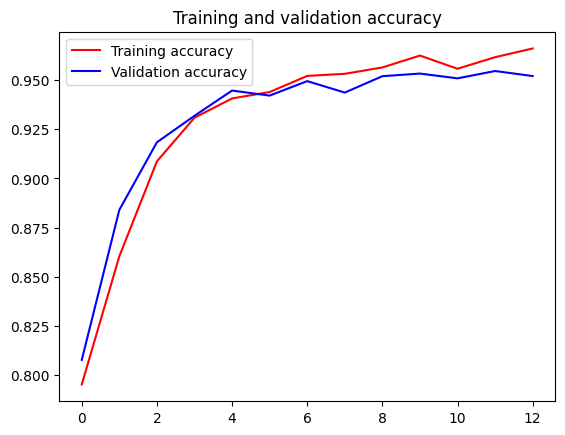

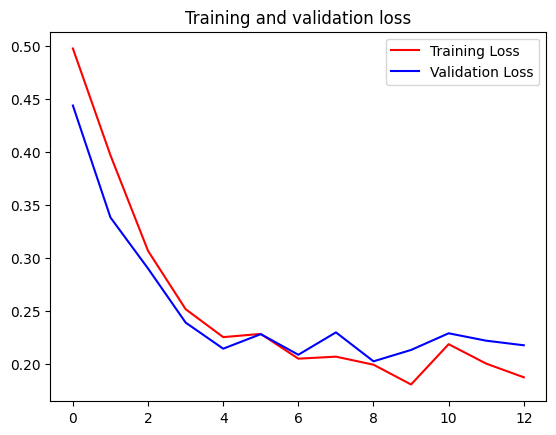

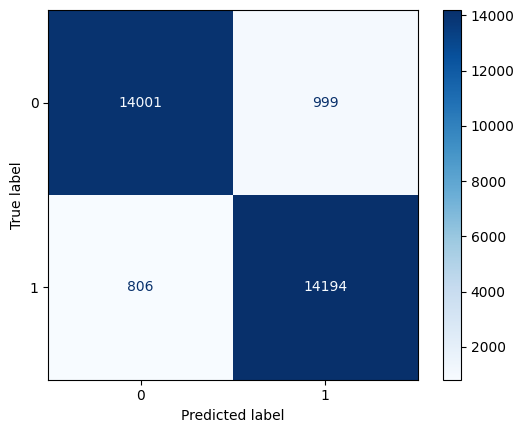

In [21]:
validate_model_bilstm(model, history, test_padded, y_test)

#### VALIDATION ####
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      1375
           1       0.00      0.00      0.00         3

    accuracy                           0.84      1378
   macro avg       0.50      0.42      0.46      1378
weighted avg       1.00      0.84      0.91      1378



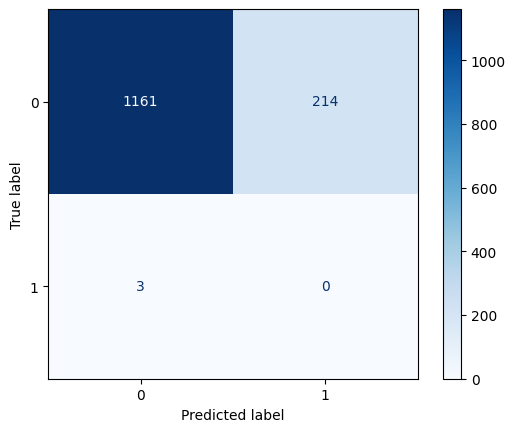

In [29]:
df_essays = pd.read_csv('data/extras/train_essays.csv', header=0)
predict_new_data(model, tokenizer, df_essays)

In [30]:
df_palm = pd.read_csv('data/extras/LLM_generated_essay_PaLM.csv', header=0)
df_falcon = pd.read_csv('data/extras/falcon_180b_v1.csv', header=0)
df_llama = pd.read_csv('data/extras/llama_70b_v1.csv', header=0)

df_llama.rename(columns={'generated_text': 'text'}, inplace=True)
df_falcon.rename(columns={'generated_text': 'text'}, inplace=True)

df_falcon['generated'] = np.ones(df_falcon.shape[0])
df_llama['generated'] = np.ones(df_llama.shape[0])

df_extras = pd.concat([df_palm[['text', 'generated']], df_falcon[['text', 'generated']], df_llama[['text', 'generated']]], axis=0)
print(df_extras.shape)
df_extras.head()

(3611, 2)


,text,generated
0,## The Advantages of Limiting Car Usage\n\nIn ...,1.0
1,"The United States is a car-dependent nation, w...",1.0
2,"In recent years, there has been a growing move...",1.0
3,"In recent years, there has been a growing move...",1.0
4,"In the past few decades, the United States has...",1.0


#### VALIDATION ####
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step
Classification report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.54      0.70      3611

    accuracy                           0.54      3611
   macro avg       0.50      0.27      0.35      3611
weighted avg       1.00      0.54      0.70      3611



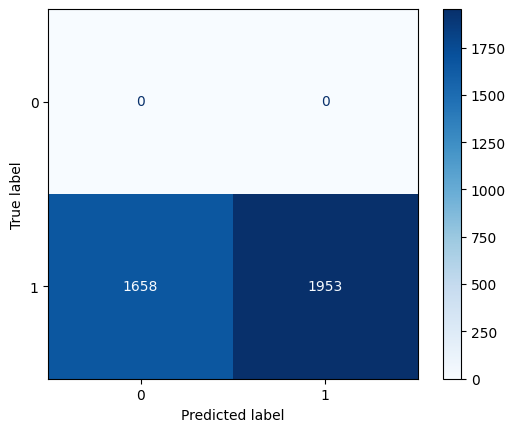

In [31]:
predict_new_data(model, tokenizer, df_extras)